In [1]:
# Load and Merge the Data

import pandas as pd

# Load datasets
train = pd.read_csv("train_2017.csv")
properties = pd.read_csv("properties_2017.csv")
sample_submission = pd.read_csv("sample_submission.csv")

# Merge train and properties on 'parcelid'
df = pd.merge(train, properties, on="parcelid", how="left")

# Log
print("Train shape:", train.shape)
print("Properties shape:", properties.shape)
print("Merged shape:", df.shape)


C:\Users\MucahitYumusakT\AppData\Local\Temp\ipykernel_8532\2857178867.py:7: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  properties = pd.read_csv("properties_2017.csv")


Train shape: (77613, 3)
Properties shape: (2985217, 58)
Merged shape: (77613, 60)


In [2]:
# Exploratory Data Analysis (EDA)

# Missing Value Analysis

# Calculate missing value ratio for each column
missing_ratio = df.isnull().mean().sort_values(ascending=False)

# Display top 15 columns with highest missing ratio
missing_ratio.head(15)


buildingclasstypeid         0.999807
finishedsquarefeet13        0.999459
basementsqft                0.999356
storytypeid                 0.999356
yardbuildingsqft26          0.999098
fireplaceflag               0.997784
architecturalstyletypeid    0.997333
typeconstructiontypeid      0.997127
finishedsquarefeet6         0.995027
pooltypeid10                0.994009
decktypeid                  0.992089
poolsizesum                 0.988803
pooltypeid2                 0.986162
hashottuborspa              0.980171
yardbuildingsqft17          0.969168
dtype: float64

These columns are almost completely missing, meaning there's a 96–99% data loss. In this case, we'll:<br>
Drop High-Null Columns.<br>
It's best to exclude columns that are mostly empty from the analysis, such as the following:<br>

In [3]:
# Drop columns with more than 96% missing values

threshold = 0.96
cols_to_drop = missing_ratio[missing_ratio > threshold].index.tolist()
df.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped {len(cols_to_drop)} columns with more than {threshold*100}% missing values.")


Dropped 18 columns with more than 96.0% missing values.


In [4]:
# Identify column types

categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("🟦 Numerical columns count:", len(numerical_cols))
print("🟨 Categorical columns count:", len(categorical_cols))


🟦 Numerical columns count: 39
🟨 Categorical columns count: 3


In [5]:
# Fill missing numerical values with median
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill missing categorical values with mode
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


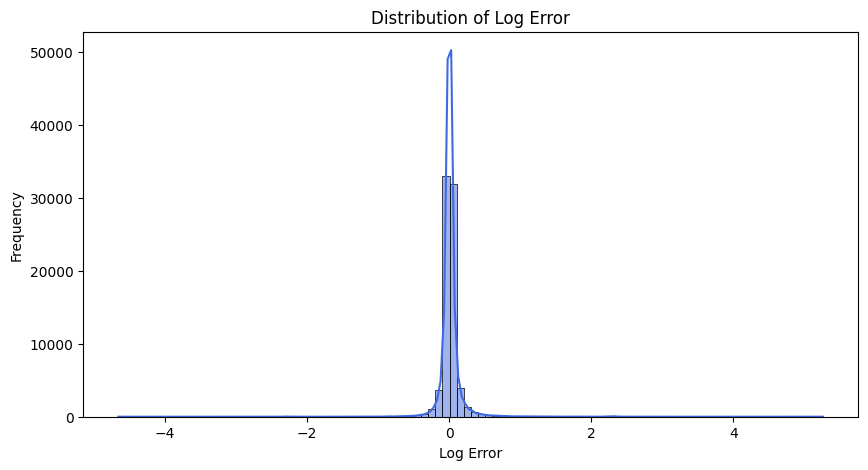

count    77613.000000
mean         0.016755
std          0.170887
min         -4.655420
25%         -0.024325
50%          0.006670
75%          0.039295
max          5.262999
Name: logerror, dtype: float64


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution plot of logerror
plt.figure(figsize=(10, 5))
sns.histplot(df['logerror'], kde=True, bins=100, color='royalblue')
plt.title("Distribution of Log Error")
plt.xlabel("Log Error")
plt.ylabel("Frequency")
plt.show()

# Basic statistics
print(df['logerror'].describe())


The distribution of the target variable, Logerror, is concentrated in the center, but there are a few outliers at the edges. Such outliers can degrade the model's performance.

In [7]:
df = df[df['logerror'].between(-0.4, 0.4)]


In [8]:
print("✅ Filtered DataFrame shape:", df.shape)

✅ Filtered DataFrame shape: (75868, 42)


C:\Users\MucahitYumusakT\AppData\Local\Temp\ipykernel_8532\1425225333.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="coolwarm")


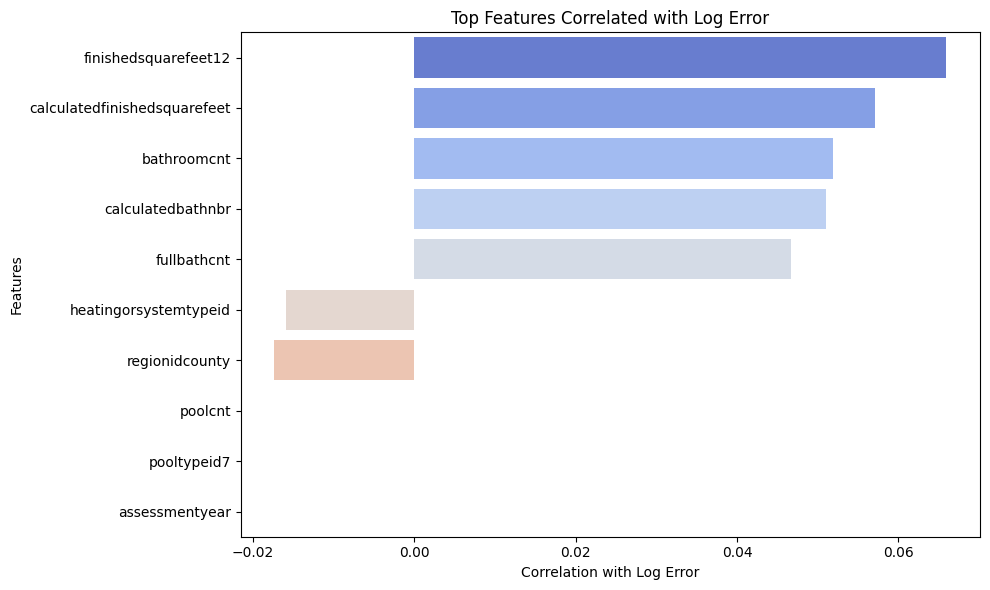

In [9]:
# Correlation Analysis

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Get correlation with target
logerror_corr = correlation_matrix['logerror'].drop('logerror').sort_values(ascending=False)

# Show top positively and negatively correlated features
top_positive = logerror_corr.head(5)
top_negative = logerror_corr.tail(5)

# Combine for visualization
top_features = pd.concat([top_positive, top_negative])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette="coolwarm")
plt.title("Top Features Correlated with Log Error")
plt.xlabel("Correlation with Log Error")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


#### The most positively correlated variables
- finishedsquarefeet12

- calculatedfinishedsquarefeet

- bathroomcnt

- calculatedbathnbr

- fullbathcnt

#### The most negatively correlated variables
- heatingorsystemtypeid

- regionidcounty

In [10]:
# Train/Test Split + Scaling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop target
X = df.drop(['logerror', 'parcelid', 'transactiondate'], axis=1)
y = df["logerror"]

# Drop non-numeric columns (remove strings, dates, etc.)
X_numeric = X.select_dtypes(include=['int64', 'float64'])

# Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y, test_size=0.2, random_state=42
)

# Feature Scaling with StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [11]:
# Model Training & Evaluation 

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
import xgboost as xgb

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    preds = np.maximum(preds, 0)  # RMSLE requires non-negative predictions
    rmsle = np.sqrt(mean_squared_log_error(y_test, preds))
    results[name] = rmsle
    print(f"{name} RMSLE: {rmsle:.4f}")


LinearRegression RMSLE: 0.0826
Ridge RMSLE: 0.0826
Lasso RMSLE: 0.0829
RandomForest RMSLE: 0.0833
XGBoost RMSLE: 0.0830


#### Evaluation:
- LinearRegression and Ridge performed best.

- XGBoost and Random Forest, despite being more complex, did not perform better—indicating that the dataset is highly linear.

- Ridge is preferable because it includes regularization and is more robust to overfitting.

In [15]:
from sklearn.linear_model import LinearRegression
import joblib

# ✅ Model create
lr = LinearRegression()

# ✅ Modeli train
lr.fit(X_train_scaled, y_train)

# ✅ save
joblib.dump(lr, "linear_model.joblib")
print("✅ Model saved as linear_model.joblib")


✅ Model saved as linear_model.joblib


In [24]:
import joblib
import pickle

# after saving model
joblib.dump(model, "linear_model.joblib")

# model features save
with open("model_features.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)
